In [1]:
import numpy as np
import pandas as pd
import mne
import glob
import os
from matplotlib import pyplot as plt
from utils.freq_calculator import do_bandpass, prepare_fft
import copy
import pyxdf 

from utils.lag_calculator import (
    epoch_data,
    remove_outliers,
    replace_outliers,
    calculate_epochs_lag,
    prepare_comparisoneeg_data,
    prepare_idun_data,
    polynomial_regression_on_lag,
    best_polynomial_regression_on_lag,
    cut_throughout_data,
    cut_at_end,
    adjust_data_by_mean_lag,
    equalize_data_length,
    clean_data_from_spikes,
    cut_throughout_data_arr,
    convert_data_to_array,
    get_device_configuration
)
import config

### Upload all data

In [2]:
# folder = "Fullscalp"
# subject = "SB"
folder = "01_Pre_study"
subject = "S004"

night = "night3"

if len(glob.glob(os.path.join(folder, subject, night, "*.edf"))) != 0:
    edf_file_path = glob.glob(os.path.join(folder, subject, night, "*.edf"))[0]
    print(edf_file_path)
    comparisoneeg_raw_data = mne.io.read_raw_edf(edf_file_path, preload=True)
    comparisoneeg_time_stamps = comparisoneeg_raw_data.times
    file_extention = 'edf'
else:
    print('No edf file present in the folder')
if len(glob.glob(os.path.join(folder, subject, night, "*.xdf"))) !=0 :  
    xdf_file_path = glob.glob(os.path.join(folder, subject, night, "*.xdf"))[0]
    print(xdf_file_path)
    comparisoneeg_raw_data, comparisoneeg_raw_header = pyxdf.load_xdf(xdf_file_path)
    comparisoneeg_time_stamps = comparisoneeg_raw_data[0]['time_stamps']
    file_extention = 'xdf'
else:
    print('No xdf file present in the folder')

#csv_file_path = glob.glob(os.path.join(folder, subject, night, "*eeg.csv"))[0]
csv_file_path = glob.glob(os.path.join(folder, subject, night, "*.csv"))[0]

# upload csv file using numpy
idun_raw_data = np.genfromtxt(csv_file_path, delimiter=",", skip_header=1)
# print the paths

print(csv_file_path)
channel_1_key,channel_2_key,scale_factor,sample_rate= get_device_configuration(config)

01_Pre_study\S004\night3\16939 - Night 2 - 555921 - output-scoring.edf
Extracting EDF parameters from c:\Users\feder\Documents\python_idun\idn-sync-data\01_Pre_study\S004\night3\16939 - Night 2 - 555921 - output-scoring.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1731599  =      0.000 ... 14429.992 secs...
No xdf file present in the folder
01_Pre_study\S004\night3\202308231917_eeg.csv


### Unpack prodigy data

In [3]:
comparisoneeg_data,comparisoneeg_channel_names = convert_data_to_array(comparisoneeg_raw_data,file_extention)

comparisoneeg_base_data_df, comparisoneeg_filtered_data_rs, resampled_times = prepare_comparisoneeg_data(
    comparisoneeg_data, config
) 
pr_freqs_rs, pr_fft_rs = prepare_fft(
    comparisoneeg_filtered_data_rs,
    config.FILTER_RANGE[0] - 5,
    config.FILTER_RANGE[1] + 5,
    config.BASE_SAMPLE_RATE,
)
# print columns of the dataframe
print(comparisoneeg_base_data_df.columns)

Index(['AUDIO', 'CHIN', 'LEFT_EEG', 'LEFT_EYE', 'MASTOID', 'POSITION',
       'RIGHT_EEG', 'RIGHT_EYE'],
      dtype='object')


Text(0.5, 1.0, 'Channel 1 - Channel 2 unfiltered')

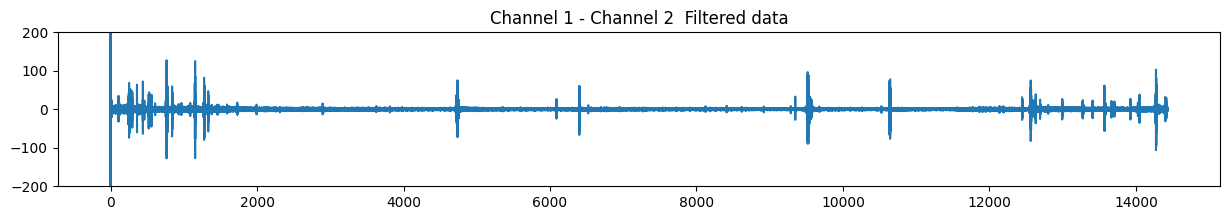

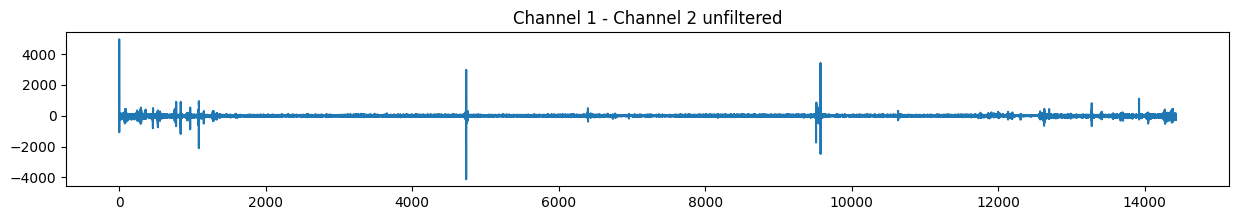

In [4]:

plt.figure(figsize=(15, 2))
plt.plot(resampled_times, comparisoneeg_filtered_data_rs)
plt.title("Channel 1 - Channel 2  Filtered data")
plt.ylim(-200, 200)
# Plot the fft of the data
plt.figure(figsize=(15, 2))
plt.plot(
    resampled_times,
    (comparisoneeg_base_data_df[channel_1_key] - comparisoneeg_base_data_df[channel_2_key])
    * scale_factor,
)
plt.title("Channel 1 - Channel 2 unfiltered")
#plt.ylim(-200, 200)

### Unpack IDUN data

In [5]:
idun_base_data, idun_filtered_data, idun_time_stamps = prepare_idun_data(
    idun_raw_data, config
)

Text(0.5, 1.0, 'IDUN Highpassed data')

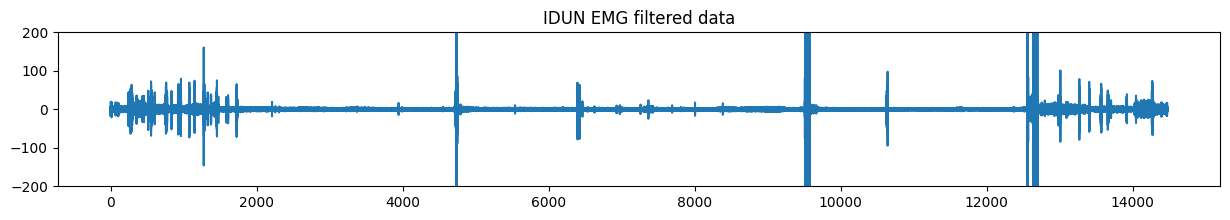

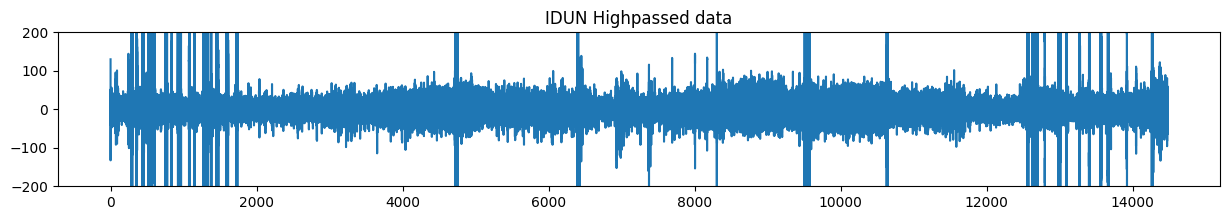

In [6]:
plt.figure(figsize=(15, 2))
plt.plot(idun_time_stamps, idun_filtered_data)
plt.ylim(-200, 200)
plt.title("IDUN EMG filtered data")

plt.figure(figsize=(15, 2))
plt.plot(idun_time_stamps, idun_base_data)
plt.ylim(-200, 200)
plt.title("IDUN Highpassed data")

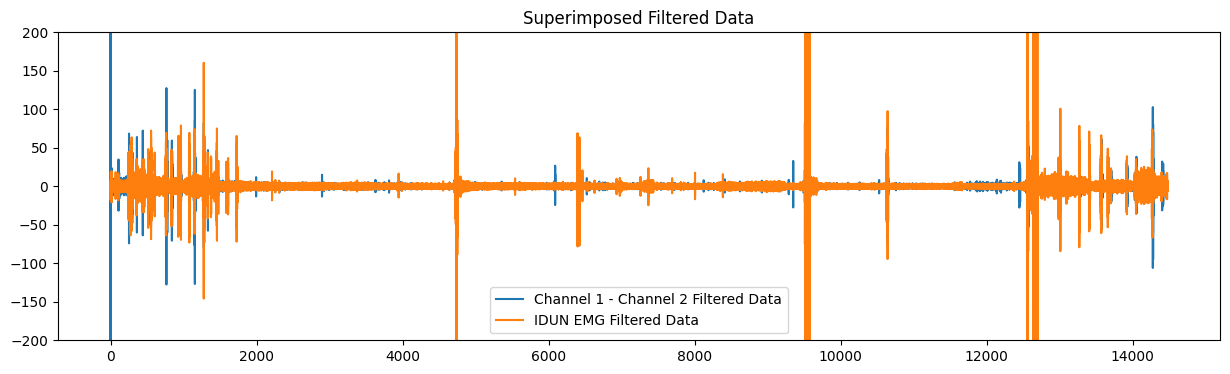

In [7]:
# Create a figure and axis
plt.figure(figsize=(15, 4))  # Adjust the figsize as needed
ax = plt.gca()

# Plot the first set of data
plt.plot(resampled_times, comparisoneeg_filtered_data_rs, label="Channel 1 - Channel 2 Filtered Data")

# Plot the second set of data on the same axes
plt.plot(idun_time_stamps, idun_filtered_data, label="IDUN EMG Filtered Data")

# Set y-axis limits
plt.ylim(-200, 200)

# Add a legend
plt.legend()

# Set a title
plt.title("Superimposed Filtered Data")

plt.show()


### Make data same length and do shifting

In [12]:
# To use the function
(
    comparisoneeg_clipped_data,
    idun_clipped_data,
    idun_base_clipped_data,
    comparisoneeg_base_clipped_df,
    same_times,
) = equalize_data_length(
    comparisoneeg_filtered_data_rs,
    idun_filtered_data,
    idun_base_data,
    comparisoneeg_base_data_df,
    config,
    comparisoneeg_time_stamps,
    idun_time_stamps
)

IDUN data is longer with 43.604 seconds, cutting from end of IDUN data


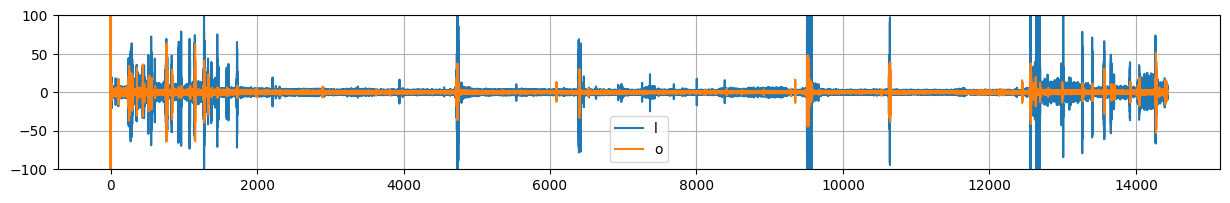

In [13]:
x_start = 0
range_viz = 20000
# create indeces from second limits
x_start_index = int(x_start * config.BASE_SAMPLE_RATE)
range_viz_index = int(range_viz * config.BASE_SAMPLE_RATE)


plt.figure(figsize=(15, 2))
plt.plot(same_times[x_start_index:x_start_index+range_viz_index], idun_clipped_data[x_start_index:x_start_index+range_viz_index], label="idun")
plt.plot(same_times[x_start_index:x_start_index+range_viz_index], 0.5 * comparisoneeg_clipped_data[x_start_index:x_start_index+range_viz_index], label=config.DEVICE)
plt.legend("lower right")
plt.ylim(-100, 100)
plt.grid()

### ------------------------------------------------------------------------------------------------

### Calculate lag

In [14]:
# extract only the first 1000 seconds
comparisoneeg_clipped_temp_data = copy.deepcopy(comparisoneeg_clipped_data)
idun_clipped_temp_data = copy.deepcopy(idun_clipped_data)

search_size = config.FIRST_LAG_EPOCH_SIZE

comparisoneeg_epochs = epoch_data(comparisoneeg_clipped_temp_data, search_size)
idun_epochs = epoch_data(idun_clipped_temp_data, search_size)
# extract only the f

In [15]:
correlation_arr, max_corr_arr, lag_arr = calculate_epochs_lag(
    comparisoneeg_epochs, idun_epochs
)
lag_arr_copy = lag_arr[1:].copy()

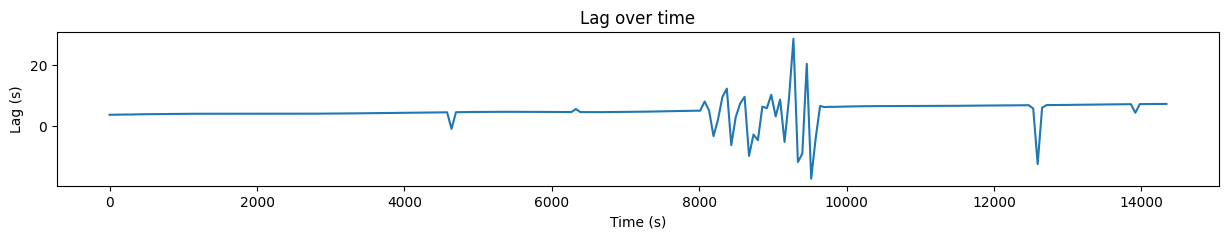

In [19]:
plt.figure(figsize=(15, 2))
# create a time array based on config.FIRST_LAG_EPOCH_SIZE and length of lag_arr_copy
plot_time_arr = np.linspace(
    0, len(lag_arr_copy) * config.FIRST_LAG_EPOCH_SIZE, len(lag_arr_copy)
)
# convert  to seconds
plot_time_arr = plot_time_arr / config.BASE_SAMPLE_RATE
plt.title("Lag over time")
plt.xlabel("Time (s)")
plt.ylabel("Lag (s)")
plt.plot(plot_time_arr, np.array(lag_arr_copy) / config.BASE_SAMPLE_RATE)

### Cut based on first analysis

In [20]:
lag_arr = np.array(lag_arr)
lag_initial = lag_arr[:20]
lag_initial = remove_outliers(lag_initial)
lag_mean = lag_initial[0]

# cut the lag_mean data from the start of idun_clipped_data if it is positive or from the start of  if negative
if lag_mean < 0:
    idun_cut_data = idun_clipped_data[-lag_mean:]
    idun_base_cut_data = idun_base_clipped_data[-lag_mean:]
    comparisoneeg_cut_data = comparisoneeg_clipped_data[:-(-lag_mean)]
    comparisoneeg_base_cut_df = comparisoneeg_base_clipped_df[:-(-lag_mean)].reset_index(drop=True)
else:
    idun_cut_data = idun_clipped_data[:-(lag_mean)]
    idun_base_cut_data = idun_base_clipped_data[:-(lag_mean)]
    comparisoneeg_cut_data = comparisoneeg_clipped_data[lag_mean:]
    comparisoneeg_base_cut_df = comparisoneeg_base_clipped_df[lag_mean:].reset_index(drop=True)

lag_mean:  3.636


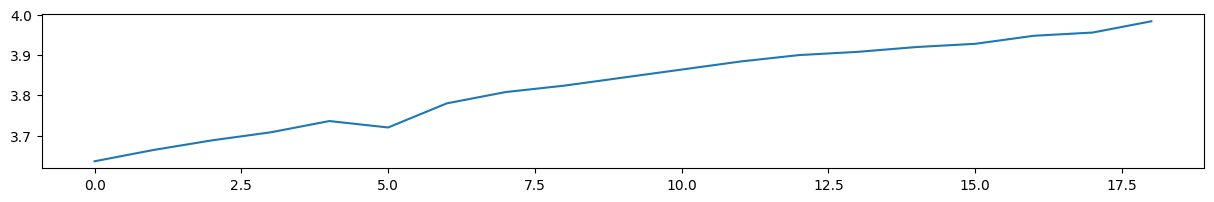

In [21]:
# plot the data
plt.figure(figsize=(15, 2))
plt.plot(lag_initial / config.BASE_SAMPLE_RATE, label="idun")
print("lag_mean: ", lag_mean / config.BASE_SAMPLE_RATE)

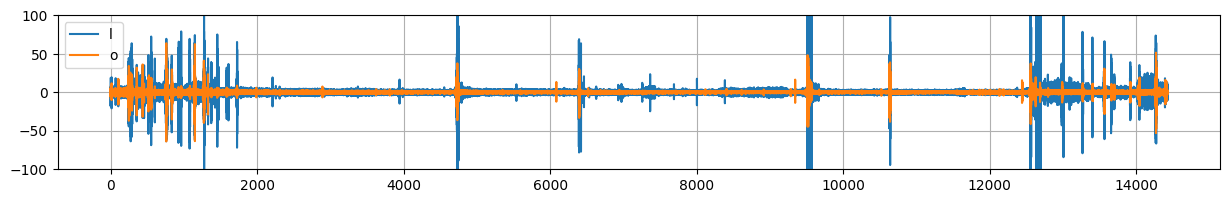

In [22]:
# plot the data
plt.figure(figsize=(15, 2))
time_seconds = np.arange(len(idun_cut_data)) / config.BASE_SAMPLE_RATE
plt.plot(time_seconds[x_start_index:x_start_index+range_viz_index], idun_cut_data[x_start_index:x_start_index+range_viz_index], label="idun")
plt.plot(time_seconds[x_start_index:x_start_index+range_viz_index], 0.5 * comparisoneeg_cut_data[x_start_index:x_start_index+range_viz_index], label=config.DEVICE)
plt.legend("lower right")
plt.ylim(-100, 100)
plt.grid()

### Do a more fine grained sync

In [23]:
cutted_comparisoneeg_epochs = epoch_data(comparisoneeg_cut_data, config.SECOND_LAG_EPOCH_SIZE)
cutted_idun_epochs = epoch_data(idun_cut_data, config.SECOND_LAG_EPOCH_SIZE)

In [24]:
fine_correlation_arr, fine_max_corr_arr, fine_lag_arr = calculate_epochs_lag(
    cutted_comparisoneeg_epochs, cutted_idun_epochs
)

(-5.0, 15.0)

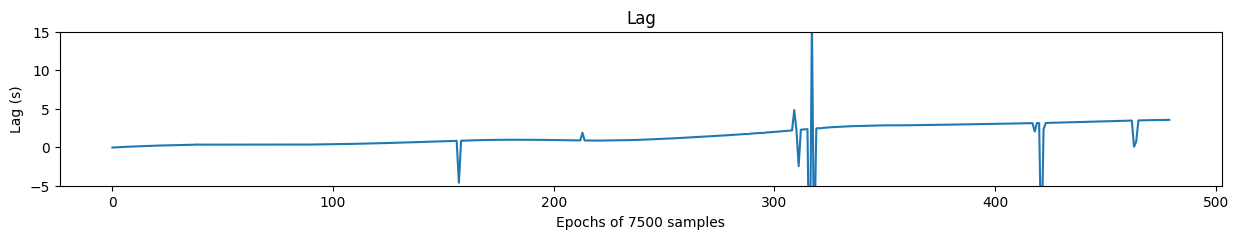

In [25]:
fine_lag_arr_copy = fine_lag_arr.copy()
plt.figure(figsize=(15, 2))
plt.plot(np.array(fine_lag_arr_copy) / 250)
plt.title("Lag")
plt.xlabel(f"Epochs of {config.SECOND_LAG_EPOCH_SIZE} samples")
plt.ylabel("Lag (s)")
plt.ylim(-5, 15)

### Do some cleaning on lag estimation

### ------------------------------------------------------------------------------------------------

In [26]:
DISCONTINUITY_THRESHOLD = config.DISCONTINUITY_THRESHOLD
# save as txt file the correlation strictness
np.savetxt(
    os.path.join(folder, subject, night, "discontinuity_threshold.txt"),
    [DISCONTINUITY_THRESHOLD],
    delimiter=",",
)

### ------------------------------------------------------------------------------------------------

Text(0.5, 1.0, 'Lag')

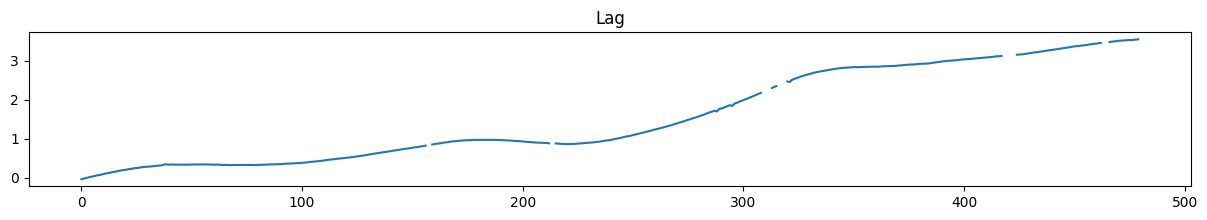

In [27]:

cleaned_fine_lag_arr = clean_data_from_spikes(fine_lag_arr_copy, DISCONTINUITY_THRESHOLD)
plt.figure(figsize=(15, 2))
plt.plot(cleaned_fine_lag_arr / config.BASE_SAMPLE_RATE)
plt.title("Lag")

### Fit a curve to the data

### ------------------------------------------------------------------------------------------------

In [28]:
# Find the best polynomial degree
best_polynomial_degree = best_polynomial_regression_on_lag(
    cleaned_fine_lag_arr, config
)
np.savetxt(
    os.path.join(folder, subject, night, "best_polynomial_degree.txt"),
    [best_polynomial_degree],
    delimiter=",",
)

# Compute the linear regression lag
linear_regression_lag = polynomial_regression_on_lag(best_polynomial_degree,cleaned_fine_lag_arr)

Degree: 2  , MAE: 153.9860615146299
Degree: 3  , MAE: 157.7744624131788
Degree: 4  , MAE: 153.90300388419539
Degree: 5  , MAE: 154.2358492534261
Degree: 6  , MAE: 153.84494646188767
Degree: 7  , MAE: 153.72940748954753
Degree: 8  , MAE: 153.60285609853491
Degree: 9  , MAE: 156.62678406131852
Degree: 10  , MAE: 160.4408320890985
Best Polynomial Degree: 8
Best Mean Absolute Error: 153.60285609853491


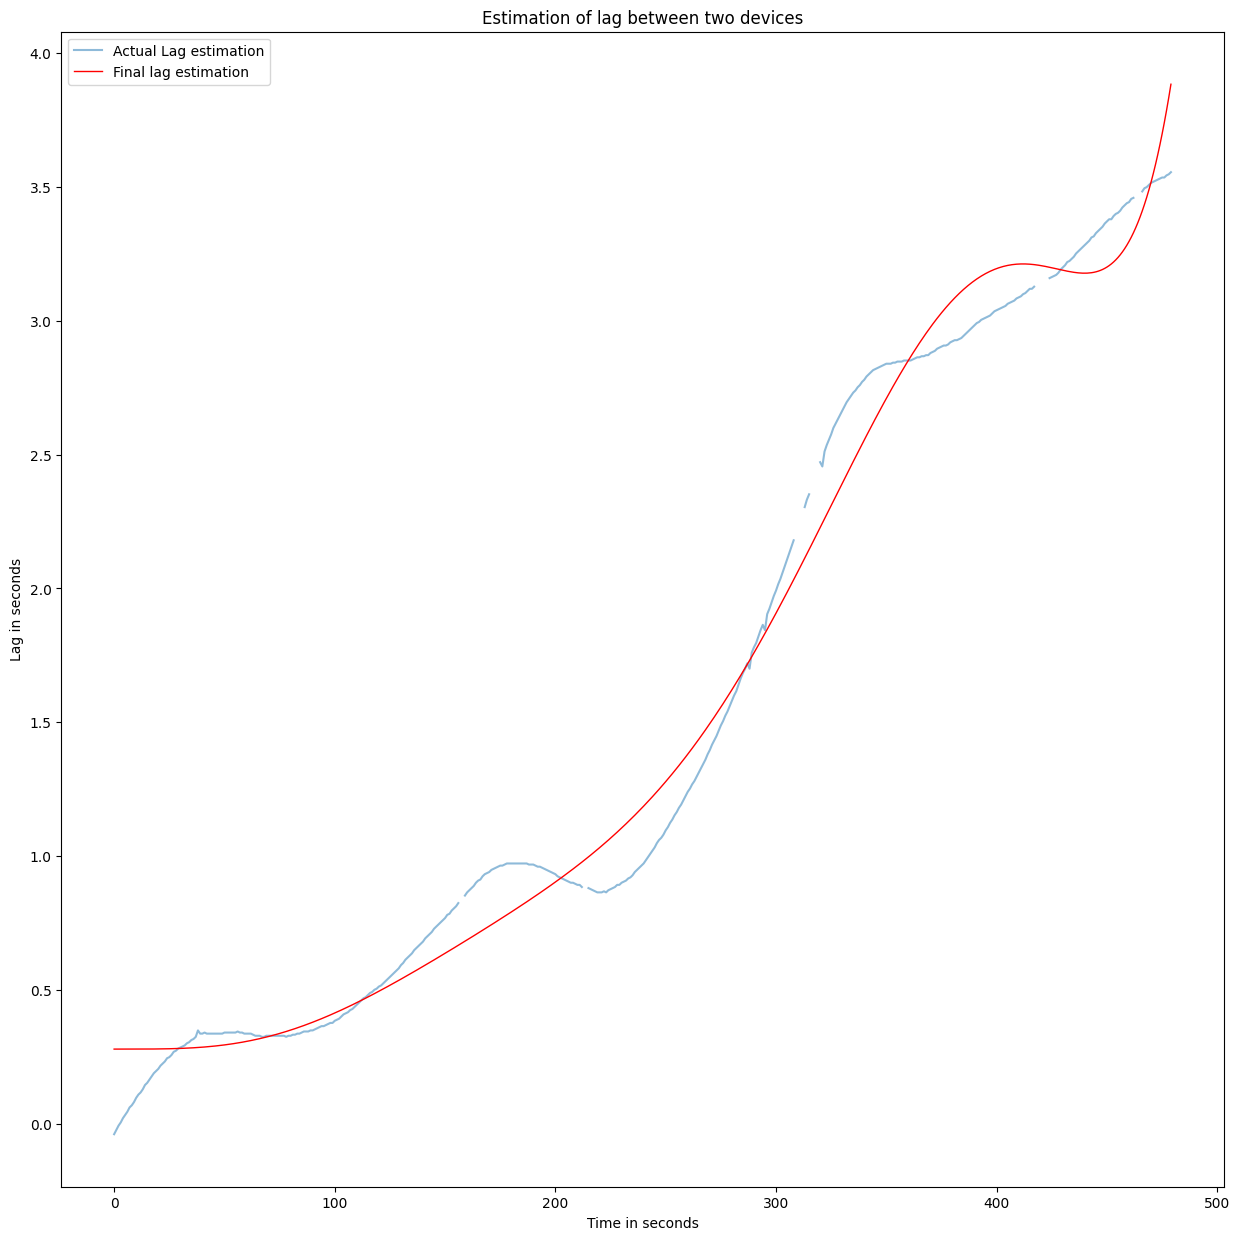

In [29]:
# Plotting the regression curve
plt.figure(figsize=(15, 15))
plt.plot(cleaned_fine_lag_arr / config.BASE_SAMPLE_RATE, label="Actual Lag estimation", alpha=0.5)
plt.plot(linear_regression_lag / config.BASE_SAMPLE_RATE, "r-", label="Final lag estimation", linewidth=1)
plt.title("Estimation of lag between two devices")
plt.xlabel("Time in seconds")
plt.ylabel("Lag in seconds")
plt.legend()
plt.savefig(
    os.path.join(folder, subject, night, "lag_estimation.png"),
    dpi=300,
    bbox_inches="tight",
)

### Create linear knots

In [30]:
x_axis_simulated = np.linspace(
    0, len(linear_regression_lag) - 1, len(linear_regression_lag)
)  # This will be 0 to 718
x_knots = np.linspace(
    0, len(linear_regression_lag) - 1, config.TOTAL_LINEAR_SEGMENTS + 1
)
y_knots = linear_regression_lag[
    (x_knots).astype(int)
]  # Directly get the y-values from y_pred

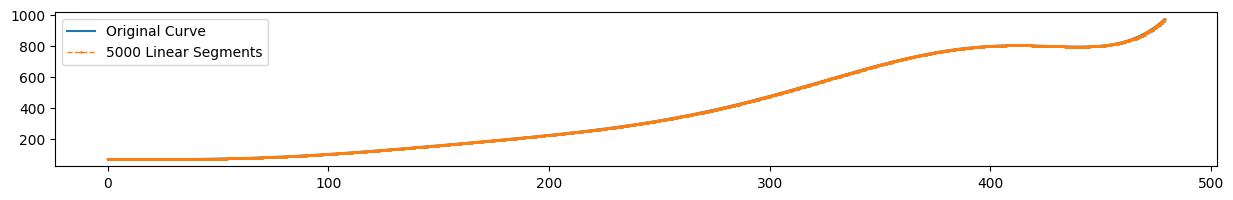

In [31]:
# Plot
plt.figure(figsize=(15, 2))
plt.plot(x_axis_simulated, linear_regression_lag, label="Original Curve")
plt.plot(
    x_knots,
    y_knots,
    label=f"{config.TOTAL_LINEAR_SEGMENTS} Linear Segments",
    linestyle="--",
    marker="o",
    linewidth=1,
    markersize=1,
)
plt.legend()
plt.show()

### Use the Linear lines to estimate the difference in sampling rates and apply

In [32]:
point_size = config.SECOND_LAG_EPOCH_SIZE
adjustment_epoch_size = int(len(comparisoneeg_cut_data) / config.TOTAL_LINEAR_SEGMENTS)
lag_positions = np.arange(0, len(comparisoneeg_cut_data), adjustment_epoch_size)
cumulative_lags = y_knots.astype(int)
lag_sizes = np.diff(cumulative_lags)

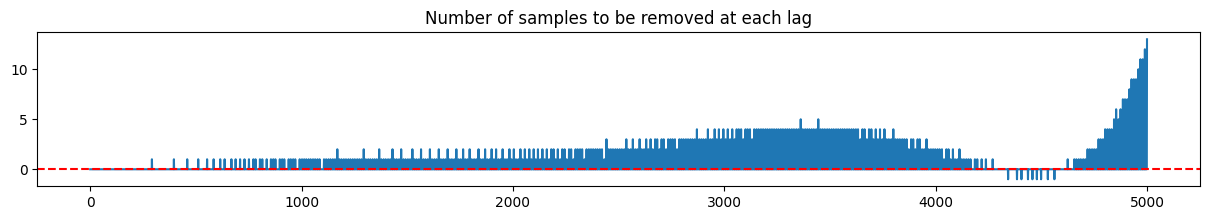

In [33]:
plt.figure(figsize=(15, 2))
plt.plot(lag_sizes)
plt.title("Number of samples to be removed at each lag")
plt.axhline(y=0, color="r", linestyle="--")

### Cut the data throughout and at the end

In [34]:
if np.sum(lag_sizes < 0) > np.sum(lag_sizes > 0):
    print("Pruning IDUN data")
    idun_data_pruned, idun_base_pruned = cut_throughout_data_arr(
        idun_cut_data, idun_base_cut_data, lag_positions, -cumulative_lags
    )
    comparisoneeg_data_pruned = copy.deepcopy(comparisoneeg_cut_data)
    comparisoneeg_base_pruned_df = copy.deepcopy(comparisoneeg_base_cut_df)
else:
    print("Pruning ", config.DEVICE, " data")
    comparisoneeg_data_pruned, comparisoneeg_base_pruned_df = cut_throughout_data(
    comparisoneeg_cut_data, comparisoneeg_base_cut_df, lag_positions, cumulative_lags
    )
    idun_data_pruned = copy.deepcopy(idun_cut_data)
    idun_base_pruned = copy.deepcopy(idun_base_cut_data)

(
    comparisoneeg_data_pruned,
    comparisoneeg_base_pruned_df,
    idun_data_pruned,
    idun_base_pruned,
) = cut_at_end(
    comparisoneeg_data_pruned,
    comparisoneeg_base_pruned_df,
    idun_data_pruned,
    idun_base_pruned,
)

Pruning  PRODIGY  data


In [35]:
final_comparisoneeg_epochs = epoch_data(
    comparisoneeg_data_pruned, config.SECOND_LAG_EPOCH_SIZE
)
final_idun_epochs = epoch_data(idun_data_pruned, config.SECOND_LAG_EPOCH_SIZE)

In [36]:
final_correlation_arr, final_max_corr_arr, final_lag_arr = calculate_epochs_lag(
    final_comparisoneeg_epochs, final_idun_epochs
)

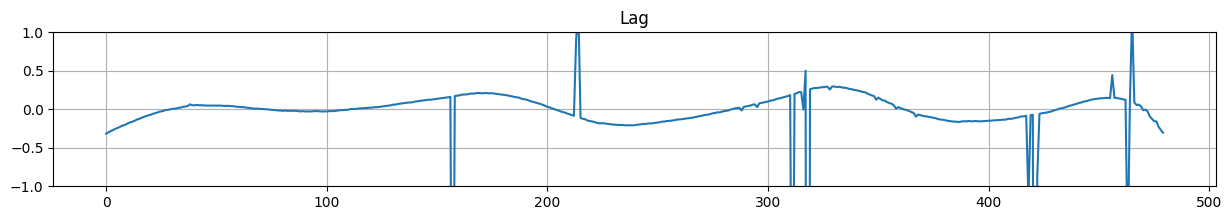

In [37]:
final_lag_arr_copy = final_lag_arr.copy()
plt.figure(figsize=(15, 2))
plt.plot(np.array(final_lag_arr) / config.BASE_SAMPLE_RATE)
plt.title("Lag")
plt.ylim(-1, 1)
plt.grid()

### Clean the lags

In [38]:
cleaned_final_lag_arr = replace_outliers(final_lag_arr_copy)
# rfind where the values are nan
nan_idx = np.argwhere(np.isnan(cleaned_final_lag_arr))
# remove the nan values
mean_final_lag = np.mean(np.delete(cleaned_final_lag_arr, nan_idx, axis=0))

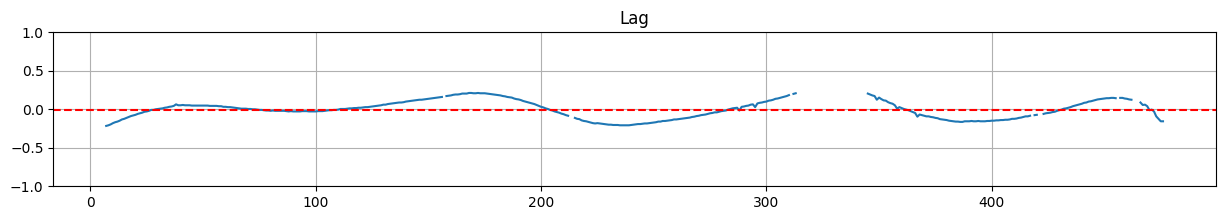

In [39]:
plt.figure(figsize=(15, 2))
plt.plot(np.array(cleaned_final_lag_arr) / config.BASE_SAMPLE_RATE)
# plot the mean_final_lag as a horizontal line
plt.axhline(y=mean_final_lag / config.BASE_SAMPLE_RATE, color="r", linestyle="--")
plt.title("Lag")
plt.ylim(-1, 1)
plt.grid()

### Remove this final shift

In [46]:
idun_data_pruned

array([17.75486047, 12.58875775,  0.66935108, ..., -1.48543297,
        2.31049602,  4.46526033])

In [40]:
(
    shifted_final_comparisoneeg_arr,
    shifted_final_comparisoneeg_base_df,
    shifted_final_idun_arr,
    shifted_final_idun_base_arr,
) = adjust_data_by_mean_lag(
    mean_final_lag,
    comparisoneeg_data_pruned,
    comparisoneeg_base_pruned_df,
    idun_data_pruned,
    idun_base_pruned,
)

In [ ]:
def adjust_data_by_mean_lag(
    mean_final_lag,
    comparisoneeg_adjusted_final_arr,
    comparisoneeg_adjusted_base_final_df,
    idun_adjusted_final_arr,
    idun_adjusted_base_final_arr,
):
    if int(mean_final_lag) >= 0:
        shifted_final_comparisoneeg_arr = comparisoneeg_adjusted_final_arr[int(mean_final_lag) :]
        shifted_final_comparisoneeg_base_df = comparisoneeg_adjusted_base_final_df[
            int(mean_final_lag) :
        ].reset_index(drop=True)

        shifted_final_idun_arr = idun_adjusted_final_arr[: -int(mean_final_lag)]
        shifted_final_idun_base_arr = idun_adjusted_base_final_arr[
            : -int(mean_final_lag)
        ]
    else:
        shifted_final_comparisoneeg_arr = comparisoneeg_adjusted_final_arr[
            : -(-int(mean_final_lag))
        ]
        shifted_final_comparisoneeg_base_df = comparisoneeg_adjusted_base_final_df[
            : -(-int(mean_final_lag))
        ].reset_index(drop=True)

        shifted_final_idun_arr = idun_adjusted_final_arr[-int(mean_final_lag) :]
        shifted_final_idun_base_arr = idun_adjusted_base_final_arr[
            -int(mean_final_lag) :
        ]

    return (
        shifted_final_comparisoneeg_arr,
        shifted_final_comparisoneeg_base_df,
        shifted_final_idun_arr,
        shifted_final_idun_base_arr,
    )


In [62]:
def adjust_data_by_mean_lag(
    mean_final_lag,
    comparisoneeg_adjusted_final_arr,
    comparisoneeg_adjusted_base_final_df,
    idun_adjusted_final_arr,
    idun_adjusted_base_final_arr,
):
    if int(mean_final_lag) > 0:
        shifted_final_comparisoneeg_arr = comparisoneeg_adjusted_final_arr[int(mean_final_lag) :]
        shifted_final_comparisoneeg_base_df = comparisoneeg_adjusted_base_final_df[
            int(mean_final_lag) :
        ].reset_index(drop=True)
        shifted_final_idun_arr = idun_adjusted_final_arr[: -int(mean_final_lag)]
        shifted_final_idun_base_arr = idun_adjusted_base_final_arr[
            : -int(mean_final_lag)
        ]
    elif int(mean_final_lag) < 0:
        shifted_final_comparisoneeg_arr = comparisoneeg_adjusted_final_arr[
            : -(-int(mean_final_lag))
        ]
        shifted_final_comparisoneeg_base_df = comparisoneeg_adjusted_base_final_df[
            : -(-int(mean_final_lag))
        ].reset_index(drop=True)

        shifted_final_idun_arr = idun_adjusted_final_arr[-int(mean_final_lag) :]
        shifted_final_idun_base_arr = idun_adjusted_base_final_arr[
            -int(mean_final_lag) :
        ]
    else: 
        shifted_final_comparisoneeg_arr = comparisoneeg_adjusted_final_arr
        shifted_final_comparisoneeg_base_df = comparisoneeg_adjusted_base_final_df
        shifted_final_idun_arr = idun_adjusted_final_arr
        shifted_final_idun_base_arr = idun_adjusted_base_final_arr


    return (
        shifted_final_comparisoneeg_arr,
        shifted_final_comparisoneeg_base_df,
        shifted_final_idun_arr,
        shifted_final_idun_base_arr,
    )

In [63]:
shifted_final_comparisoneeg_epochs = epoch_data(
    shifted_final_comparisoneeg_arr, config.SECOND_LAG_EPOCH_SIZE
)
shifted_final_idun_epochs = epoch_data(
    shifted_final_idun_arr, config.SECOND_LAG_EPOCH_SIZE
)
(
    shifted_final_correlation_arr,
    shifted_final_max_corr_arr,
    shifted_final_lag_arr,
) = calculate_epochs_lag(shifted_final_comparisoneeg_epochs, shifted_final_idun_epochs)

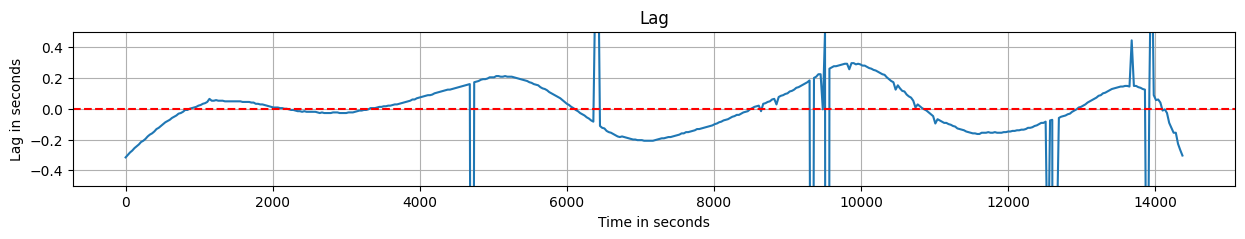

In [64]:
plt.figure(figsize=(15, 2))
# create time array kby muliplying the length of the array by the epoch size
time_seconds = (
    np.arange(len(shifted_final_lag_arr))
    * config.SECOND_LAG_EPOCH_SIZE
    / config.BASE_SAMPLE_RATE
)
plt.plot(time_seconds, np.array(shifted_final_lag_arr) / config.BASE_SAMPLE_RATE)
plt.axhline(y=0, color="r", linestyle="--")
plt.title("Lag")
plt.xlabel("Time in seconds")
plt.ylabel("Lag in seconds")
plt.ylim(-0.5, 0.5)
plt.grid()
# save image of lag
plt.savefig(os.path.join(folder, subject, night, f"{subject}_{night}_lag.png"))

### Plot final filtered data

c:\Users\feder\envs\sampling_freq\lib\site-packages\IPython\core\events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\feder\envs\sampling_freq\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


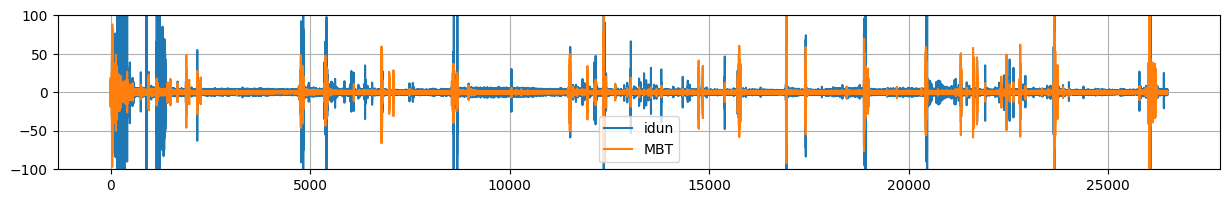

In [34]:
plt.figure(figsize=(15, 2))
# create a seconds axis
time_seconds = np.arange(len(shifted_final_idun_arr)) / config.BASE_SAMPLE_RATE
plt.plot(time_seconds, shifted_final_idun_arr, label="idun")
plt.plot(time_seconds, 0.5 * shifted_final_comparisoneeg_arr, label=config.DEVICE)
plt.legend()
plt.ylim(-100, 100)
plt.grid()

### Final validation, plot final raw data

(6620161, 38)
(6620161,)


C:\Users\feder\AppData\Local\Temp\ipykernel_12136\812215469.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(folder, subject, night, f"{subject}_{night}_raw.png"))
C:\Users\feder\AppData\Local\Temp\ipykernel_12136\812215469.py:47: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(folder, subject, night, f"{subject}_{night}_filtered.png"))


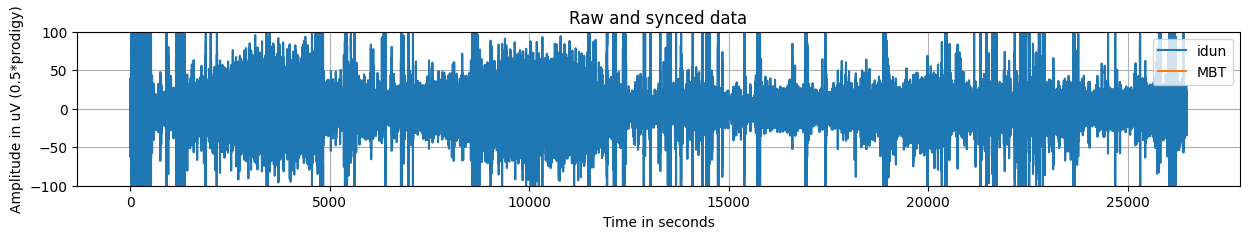

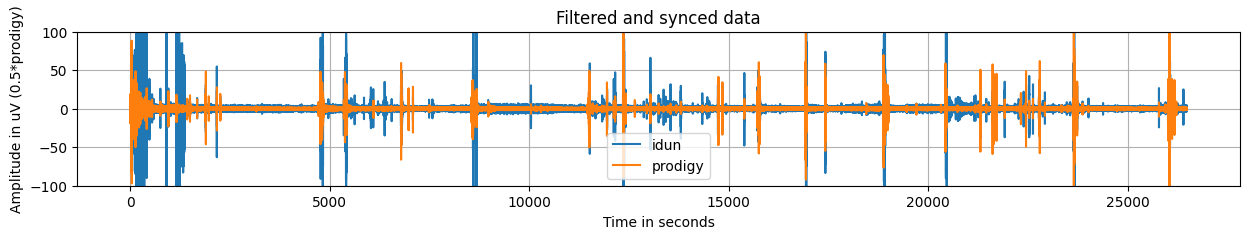

In [35]:
print(shifted_final_comparisoneeg_base_df.shape)
print(shifted_final_idun_base_arr.shape)

comparisoneeg_channel_1_data = np.array(shifted_final_comparisoneeg_base_df[channel_1_key])
comparisoneeg_channel_2_data = np.array(shifted_final_comparisoneeg_base_df[channel_2_key])
# minus right eye from left eye
comparisoneeg_channel_1_minus_2 = comparisoneeg_channel_1_data - comparisoneeg_channel_2_data
comparisoneeg_channel_1_minus_2 = (
    comparisoneeg_channel_1_minus_2 * scale_factor
)  # To get the data to same scale as ours, v to uv

comparisoneeg_filtered = do_bandpass(
    comparisoneeg_channel_1_minus_2,
    [config.FILTER_RANGE[0], config.FILTER_RANGE[1]],
    config.BASE_SAMPLE_RATE,
)

idun_filtered = do_bandpass(
    shifted_final_idun_base_arr,
    [config.FILTER_RANGE[0], config.FILTER_RANGE[1]],
    config.BASE_SAMPLE_RATE,
)


plt.figure(figsize=(15, 2))
time_seconds = np.arange(len(shifted_final_idun_base_arr)) / config.BASE_SAMPLE_RATE
plt.plot(time_seconds, shifted_final_idun_base_arr, label="idun")
plt.plot(time_seconds, 0.5 * comparisoneeg_channel_1_minus_2, label=config.DEVICE)
plt.legend()
plt.ylim(-100, 100)
plt.title("Raw and synced data")
plt.xlabel("Time in seconds")
plt.ylabel("Amplitude in uV (0.5* ", config.DEVICE, ")")
plt.savefig(os.path.join(folder, subject, night, f"{subject}_{night}_raw.png"))
plt.grid()


plt.figure(figsize=(15, 2))
time_seconds = np.arange(len(idun_filtered)) / config.BASE_SAMPLE_RATE
plt.plot(time_seconds, idun_filtered, label="idun")
plt.plot(time_seconds, 0.5 * comparisoneeg_filtered, label=config.DEVICE)
plt.legend()
plt.ylim(-100, 100)
plt.title("Filtered and synced data")
plt.xlabel("Time in seconds")
plt.ylabel("Amplitude in uV (0.5* ", config.DEVICE, ")")
plt.savefig(os.path.join(folder, subject, night, f"{subject}_{night}_filtered.png"))
plt.grid()

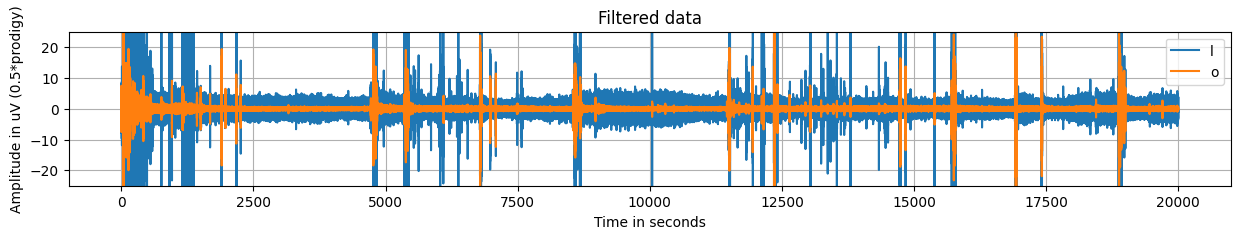

In [36]:
plt.figure(figsize=(15, 2))
time_seconds = np.arange(len(idun_filtered)) / config.BASE_SAMPLE_RATE
plt.plot(time_seconds[x_start_index:x_start_index+range_viz_index], idun_filtered[x_start_index:x_start_index+range_viz_index], label="idun")
plt.plot(time_seconds[x_start_index:x_start_index+range_viz_index], 0.2 * comparisoneeg_filtered[x_start_index:x_start_index+range_viz_index], label=config.DEVICE)
plt.legend("lower right")
plt.ylim(-25, 25)
plt.title("Filtered data")
plt.xlabel("Time in seconds")
plt.ylabel("Amplitude in uV (0.5* ", config.DEVICE, ")")
plt.grid()
plt.savefig(
    os.path.join(folder, subject, night, f"{subject}_{night}_filtered_zoom.png")
)

### Combine Dataframes

In [37]:
# create a time array based on config.BASE_SAMPLE_RATE and length of prodigy_filtered
time_array = np.linspace(
    0,
    len(shifted_final_idun_base_arr) / config.BASE_SAMPLE_RATE,
    len(shifted_final_idun_base_arr),
)
# copy the shifted_final_prodigy_base_df
synced_base_df_copy = copy.deepcopy(shifted_final_comparisoneeg_base_df)
# add shifted_final_idun_base_arr as "IDUN" column to prodigy_base_df_copy
synced_base_df_copy["IDUN"] = shifted_final_idun_base_arr
# make index of prodigy_base_df_copy as time_array
synced_base_df_copy.index = time_array

# save the dataframe as csv, and add a header indicating the sampling rate
save_path = os.path.join(folder, subject, night, f"{subject}_{night}_synced_data.csv")
synced_base_df_copy.to_csv(save_path, index=True)